## PROGETTO DI MACHINE AND DEEP LEARNING - "Immagini"

Si vuole modellare un sistema di apprendimento automatico mediante l’utilizzo del linguaggio di programmazione Python. 
L'oggetto delle analisi di questo notebook è un set di immagini.
Le appena citate analisi, verranno condotte utilizzando diversi strumenti e algoritmi per la classificazione, compresa anche una rete neurale convoluzionale. Verrà effettuata anche anomaly detection con l'approccio "OneClassSVM" il cui training set dovrà essere composto dalla classe più numerosa del dataset ed il test set da quelle restanti. Per la valutazione della qualità del detector si farà uso delle curve di ROC.

Infine, i risultati saranno valutati per misurare le prestazioni mediante il calcolo di diverse misure quali: Accuratezza; Precision; Recall; F1.


## Indice:


1.   **Get the data**
2.  **Data Analysis**
3.  **Preparazione dei dati**
4. **Classificazione**
5. **Anomaly Detection**

## 1 - Get the data
Effettuiamo le import necessarie

In [1]:
import numpy as np 
import pandas as pd
import cv2
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pkl

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import classification_report, roc_curve, auc, mean_squared_error, mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier, LocalOutlierFactor
from sklearn.svm import SVC, OneClassSVM
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, IsolationForest
from sklearn.covariance import EllipticEnvelope

import scikitplot as skplt
import tensorflow.keras.models as Models
import tensorflow.keras.layers as Layers
import tensorflow.keras.activations as Activations
import tensorflow.keras.optimizers as Optimizer

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D

dataset_dir = os.path.join("Datasets/immagini-4")
modelli_dir = os.path.join("Modelli/Immagini")

Per leggere le immagini andremo ad utilizzare la libreria open cv. Inoltre, per semplificare le elaborazioni, andremo ad applicare anche ad esse una trasformazione in scala di grigi.
Andiamo a vedere un esempio con una immagine:

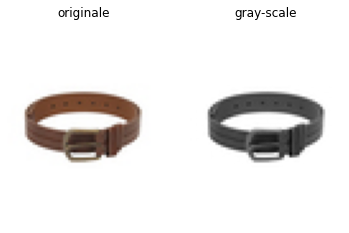

In [2]:
image1 = cv2.cvtColor(cv2.imread(os.path.join(dataset_dir,"belts_15.jpg")), cv2.COLOR_BGR2RGB)
fig, axes = plt.subplots(1,2)
axes[0].axis("off")
axes[0].set_title("originale")
axes[0].imshow(image1)
axes[1].axis("off")
axes[1].set_title("gray-scale")
image2 = cv2.cvtColor(cv2.imread(os.path.join(dataset_dir,"belts_15.jpg")), cv2.COLOR_BGR2GRAY)
axes[1].imshow(image2, cmap="gray")
plt.show()

Andiamo a vedere quanti tipi di dimensione diverse abbiamo nel nostro dataset:

In [ ]:
diz={}
for file in os.listdir(dataset_dir):
    shape = cv2.cvtColor(cv2.imread(os.path.join(dataset_dir,file)), cv2.COLOR_BGR2RGB).shape
    if shape not in diz:
        diz[shape]=1
    else:
        diz[shape]+=1
print("numero di immagini di dimensione diversa: ",len(diz))
print(diz)

Abbiamo trovato 2 tipi di dimensione:
* quella standard appartenente alla quasi totalità delle immagini
* un'altra dimensione appartenente ad una sola immagine

Possiamo operare in 2 modi: possiamo decidere di eliminare questa immagine oppure modificarla rendendo la sua dimensione uguale a tutte le altre.
Scegliamo di tenere l'immagine applicando direttamente la funzione *resize* quando andremo a prelevare le immagini dalla directory.

Per curiosità andiamo a vedere, intanto, di che immagine si tratta:

In [4]:
for file in os.listdir(dataset_dir):
    shape = cv2.cvtColor(cv2.imread(os.path.join(dataset_dir,file)), cv2.COLOR_BGR2RGB).shape
    if (shape == (60, 60, 3)):
        print(file)

sports-shoes_1114.jpg


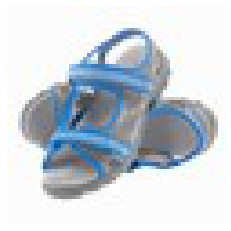

(60, 60, 3)

In [5]:
plt.axis("off")
image = cv2.cvtColor(cv2.imread(os.path.join(dataset_dir,"sports-shoes_1114.jpg")), cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
image.shape

Andiamo ora a creare il nostro dataset prelevando i file dalla directory. Possiamo recuperare le label di ogni immagine prendendo il nome del file e prelevando la stringa che precede il simbolo "_".
Definiamo una funzione che prenda le immagini dalla cartella, le trasformi in scala di grigi e le salvi in una lista. La stessa funzione andrà a creare un dizionario contenente i valori unici delle etichette.

In [2]:
def get_images(directory):
    Images=[]
    Labels=[]
    #definiamo un dizionario che andrà a contenere i tipi di etichette che abbiamo
    label_dict={}
    i=0
    for filename in os.listdir(directory):
        #Usiamo la riga sottostante per prelevare le immagini a colori
        #imm = cv2.imread(os.path.join(directory,filename))
        #noi vogliamo trasformarle in scala di grigi, quinsi usiamo la riga seguente
        imm=cv2.cvtColor(cv2.imread(os.path.join(directory,filename)), cv2.COLOR_BGR2GRAY)
        imm = cv2.resize(imm,(60,80))
        Images.append(imm)
        label=filename.split("_")[0]
        if label not in label_dict:
            label_dict[label]=i
            Labels.append(i)
            i=i+1
        else:
            Labels.append(label_dict[label])
    return (Images,Labels, label_dict)

In [3]:
Images, Labels, label_dict =get_images(dataset_dir)

Andiamo a vedere quanti valori unici abbiamo per le etichette:

In [8]:
label_dict

{'belts': 0, 'casual-shoes': 1, 'sports-shoes': 2, 'wallets': 3}

Contiamo quante sono le immagini e quante le etichette in modo da vedere se i 2 valori corrispondono:

In [9]:
print(len(Images))
print(len(Labels))

5966
5966


Trasformiamo Images e Labels da liste ad array:

In [4]:
Images = np.array(Images)
Labels = np.array(Labels)
print("Shape of Images: ",Images.shape)
print("Shape of Labels: ",Labels.shape)

Shape of Images:  (5966, 80, 60)
Shape of Labels:  (5966,)


Ricapitolando, abbiamo estratto 4 tipologie di immagini:
* **belts**
* **casual-shoes**
* **sports-shoes**
* **wallets**

## 2 - Data Analysis
In questa sezione saranno presentate delle statistiche. Vediamo innanzitutto tramite un barchart la distribuzione delle immagini all'interno del nostro Dataset. Quello che faremo è semplicemente contare le occorrenze di ogni valore univoco all'interno della lista *Labels*.

In [11]:
def bar_chart_distr(Labels, label_dict):
    plt.rcParams.update({'font.size': 13})
    colors = ['blue', 'cyan', 'brown', 'red']
    plt.figure(figsize=(13,6))
    unique, counts = np.unique(Labels, return_counts=True)
    bars = plt.bar(unique, counts, align='center', alpha=0.8, color=colors)
    index = list(label_dict.values())
    plt.xticks(unique, index)
    for bar, val in zip(bars, counts):
        plt.text(bar.get_x()+0.2, +bar.get_height(), val)
    plt.title("Distribuzione delle immagini ", fontsize=20,fontweight="bold")
    plt.show()

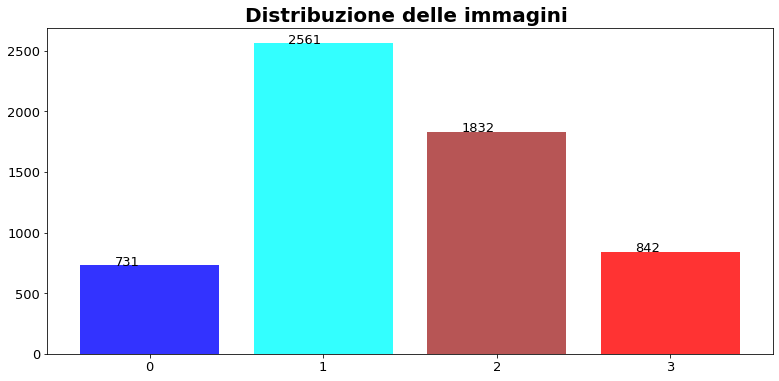

In [12]:
bar_chart_distr(Labels, label_dict)

La distribuzione delle immagini è la seguente:
* **belts** = **731**
* **casual-shoes** =**2561**
* **sports-shoes** = **1832**
* **wallets** = **842**

## 3 - Preparazione dei dati

In questa sezione ci dedicheremo alla manipolazione del dataset al fine di condurre le nostre analisi. Innanzitutto, andiamo a flattenizzare le tuple di Images per poi suddividere il dataset in *Train Set* e *Test Set*:

In [5]:
dataset_size = len(Images)
ImagesR = Images.reshape(dataset_size,-1)

print("Shape of Images: ",ImagesR.shape)
print(Images[0].shape)

Shape of Images:  (5966, 4800)
(80, 60)


In [6]:
## split train / test

x_train,x_test,y_train,y_test=train_test_split(ImagesR,Labels,train_size=0.80, test_size=0.20)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

print('Dimensioni training set: ',len(x_train), len(y_train))
print('Dimensioni validation set: ',len(x_test), len(y_test))

(4772, 4800) (4772,) (1194, 4800) (1194,)
Dimensioni training set:  4772 4772
Dimensioni validation set:  1194 1194


## 4 - Classificazione

I classificatori che verranno utilizzati per i nostri scopi sono i seguenti:
* **K Nearest Neighbors**
* **Support Vector Machine**
* **Adaptive Boosting**

### KNN


Andiamo ad utilizzare il primo classificatore:

Accuracy iterazione 0: 0.8324958123953099
Accuracy iterazione 1: 0.8207705192629816
Accuracy iterazione 2: 0.8542713567839196
Accuracy iterazione 3: 0.8425460636515912
Accuracy iterazione 4: 0.8542713567839196
Accuracy iterazione 5: 0.8509212730318257
Accuracy iterazione 6: 0.8389261744966443
Accuracy iterazione 7: 0.8338926174496645
Accuracy iterazione 8: 0.8422818791946308
Accuracy iterazione 9: 0.8557046979865772
10-fold Accuracy= 0.8426081751037063
Accuracy = 0.8442211055276382
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       147
           1       0.76      0.93      0.84       508
           2       0.87      0.60      0.71       366
           3       0.98      0.99      0.99       173

    accuracy                           0.84      1194
   macro avg       0.90      0.88      0.88      1194
weighted avg       0.85      0.84      0.84      1194



<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

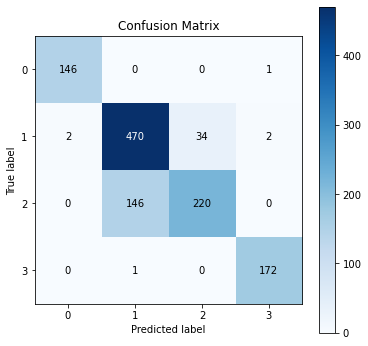

In [30]:
knn = KNeighborsClassifier(n_neighbors=7)

#valutazione dei modelli appresi con 10-fold cross-validation
train_score = cross_val_score(knn, ImagesR, Labels, cv=10)
for i in range (len(train_score)):
    print(f"Accuracy iterazione {i}: {train_score[i]}")
train_score = train_score.mean()

print(f"10-fold Accuracy= {train_score}")

knn=knn.fit(x_train, y_train)
print("Accuracy =",knn.score(x_test,y_test))

y_pred = knn.predict(x_test)
print(classification_report(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(y_test,y_pred,figsize=(6,6))

#salvataggio modello corrente
with open(os.path.join(modelli_dir,'knn.pkl'), 'wb') as file:
        pkl.dump(knn, file)

### SVM
Questo classificatore si fonda sull’idea di trovare un iperpiano che divida al meglio un set di dati in due classi, utilizzando allo scopo i seguenti passaggi:

* Cerca un iperpiano linearmente separabile o un limite di decisione che separa i valori di una classe dall’altro. Se ne esiste più di uno, cerca quello che ha margine più alto con i vettori di supporto, per migliorare l’accuratezza del modello.

* Se non dovesse trovare nulla con l'approccio lineare, SVM utilizza una mappatura non lineare per trasformare i dati di allenamento in una dimensione superiore. In questo modo, i dati di due classi possono sempre essere separati da un iperpiano, che sarà scelto per la suddivisione dei dati. 

Nelle celle seguenti verranno presentati questi due tipi di SVM, il primo mediante *linear SVM*, il secondo tramite *rbf SVM* e *polinomial SVM*.

NB: rbf sta per radial basis function.

Accuracy iterazione 0: 0.8743718592964824
Accuracy iterazione 1: 0.8458961474036851
Accuracy iterazione 2: 0.8827470686767169
Accuracy iterazione 3: 0.8693467336683417
Accuracy iterazione 4: 0.8743718592964824
Accuracy iterazione 5: 0.9028475711892797
Accuracy iterazione 6: 0.8640939597315436
Accuracy iterazione 7: 0.8674496644295302
Accuracy iterazione 8: 0.8758389261744967
Accuracy iterazione 9: 0.8741610738255033
10-fold Accuracy= 0.8731124863692064
Accuracy = 0.8835845896147404
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       147
           1       0.83      0.93      0.87       508
           2       0.88      0.73      0.80       366
           3       0.99      0.99      0.99       173

    accuracy                           0.88      1194
   macro avg       0.92      0.91      0.91      1194
weighted avg       0.89      0.88      0.88      1194



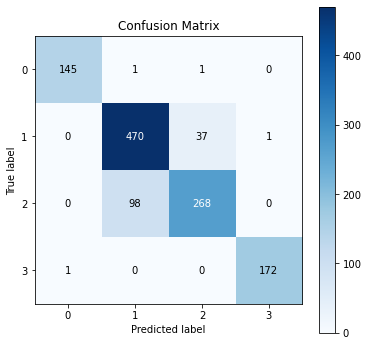

In [165]:
# rbf SVM

svm_rbf=SVC(kernel = 'rbf',random_state=34)

#valutazione dei modelli appresi con 10-fold cross-validation
train_score = cross_val_score(svm_rbf, ImagesR, Labels, cv=10)
for i in range (len(train_score)):
    print(f"Accuracy iterazione {i}: {train_score[i]}")
train_score = train_score.mean()

print(f"10-fold Accuracy= {train_score}")

svm_rbf=svm_rbf.fit(x_train,y_train)
print("Accuracy =",svm_rbf.score(x_test,y_test))

y_pred = svm_rbf.predict(x_test)
print(classification_report(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(y_test,y_pred,figsize=(6,6))

#salvataggio modello corrente
with open(os.path.join(modelli_dir,'svm_rbf.pkl'), 'wb') as file:
        pkl.dump(svm_rbf, file)

Accuracy iterazione 0: 0.8040201005025126
Accuracy iterazione 1: 0.7973199329983249
Accuracy iterazione 2: 0.8040201005025126
Accuracy iterazione 3: 0.7939698492462312
Accuracy iterazione 4: 0.7788944723618091
Accuracy iterazione 5: 0.8090452261306532
Accuracy iterazione 6: 0.7718120805369127
Accuracy iterazione 7: 0.7718120805369127
Accuracy iterazione 8: 0.7785234899328859
Accuracy iterazione 9: 0.8036912751677853
10-fold Accuracy= 0.791310860791654
Accuracy = 0.7847571189279732
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       147
           1       0.74      0.77      0.75       508
           2       0.66      0.63      0.64       366
           3       0.98      0.99      0.99       173

    accuracy                           0.78      1194
   macro avg       0.84      0.85      0.84      1194
weighted avg       0.78      0.78      0.78      1194



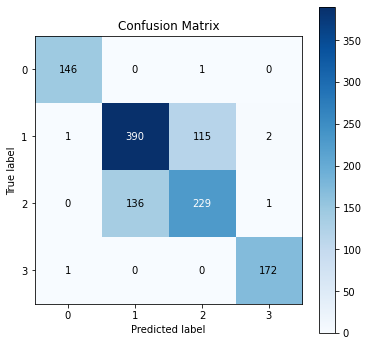

In [166]:
# linear SVM

svm_linear=SVC(kernel = 'linear',random_state=34)

#valutazione dei modelli appresi con 10-fold cross-validation
train_score = cross_val_score(svm_linear, ImagesR, Labels, cv=10)
for i in range (len(train_score)):
    print(f"Accuracy iterazione {i}: {train_score[i]}")
train_score = train_score.mean()

print(f"10-fold Accuracy= {train_score}")

svm_linear=svm_linear.fit(x_train,y_train)
print("Accuracy =",svm_linear.score(x_test,y_test))

y_pred = svm_linear.predict(x_test)
print(classification_report(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(y_test,y_pred,figsize=(6,6))

#salvataggio modello corrente
with open(os.path.join(modelli_dir,'svm_linear.pkl'), 'wb') as file:
        pkl.dump(svm_linear, file)

Accuracy iterazione 0: 0.8408710217755444
Accuracy iterazione 1: 0.8442211055276382
Accuracy iterazione 2: 0.8626465661641541
Accuracy iterazione 3: 0.8576214405360134
Accuracy iterazione 4: 0.8592964824120602
Accuracy iterazione 5: 0.8743718592964824
Accuracy iterazione 6: 0.8406040268456376
Accuracy iterazione 7: 0.8406040268456376
Accuracy iterazione 8: 0.8640939597315436
Accuracy iterazione 9: 0.8288590604026845
10-fold Accuracy= 0.8513189549537395
Accuracy = 0.8467336683417085
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       147
           1       0.81      0.85      0.83       508
           2       0.78      0.72      0.75       366
           3       0.98      0.99      0.99       173

    accuracy                           0.85      1194
   macro avg       0.89      0.89      0.89      1194
weighted avg       0.85      0.85      0.85      1194



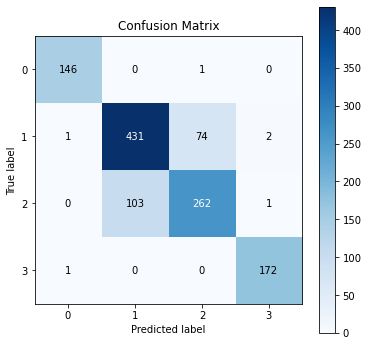

In [167]:
# polinomial SVM

svm_poly=SVC(kernel = 'poly',random_state=34)

#valutazione dei modelli appresi con 10-fold cross-validation
train_score = cross_val_score(svm_poly, ImagesR, Labels, cv=10)
for i in range (len(train_score)):
    print(f"Accuracy iterazione {i}: {train_score[i]}")
train_score = train_score.mean()

print(f"10-fold Accuracy= {train_score}")

svm_poly=svm_poly.fit(x_train,y_train)
print("Accuracy =",svm_poly.score(x_test,y_test))

y_pred = svm_poly.predict(x_test)
print(classification_report(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(y_test,y_pred,figsize=(6,6))

#salvataggio modello corrente
with open(os.path.join(modelli_dir,'svm_poly.pkl'), 'wb') as file:
        pkl.dump(svm_poly, file)

Prendendo in considerazione i risultati delle analisi effettuate con entrabi i tipi di SVM possiamo concludere che il migliore sia quello ottenuto con l'SVM di tipo rbf.

### ADABOOST
Il classificatore AdaBoost (Adaptive Boosting) fa parte della famiglia di algoritmi di boosting, che permettono di combinare più classificatori deboli in un unico classificatore forte.
Il Boosting è un metodo di ensemble per migliorare le previsioni del modello di un determinato algoritmo di apprendimento. L’idea che ne è alla base è quella di formare sequenzialmente weak learner, ognuno cercando di correggere il suo predecessore.

Questo viene fatto creando prima un modello dai dati di addestramento, in seguito viene creato un secondo modello che tenta di correggere gli errori dal primo modello.

I modelli vengono aggiunti fino a quando il set di addestramento non viene previsto perfettamente o non viene aggiunto un numero massimo di modelli.

Accuracy iterazione 0: 0.8257956448911222
Accuracy iterazione 1: 0.8207705192629816
Accuracy iterazione 2: 0.7671691792294807
Accuracy iterazione 3: 0.8274706867671692
Accuracy iterazione 4: 0.8375209380234506
Accuracy iterazione 5: 0.847571189279732
Accuracy iterazione 6: 0.8154362416107382
Accuracy iterazione 7: 0.8104026845637584
Accuracy iterazione 8: 0.837248322147651
Accuracy iterazione 9: 0.8137583892617449
10-fold Accuracy= 0.8203143795037828
Accuracy = 0.8015075376884422
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       147
           1       0.77      0.78      0.78       508
           2       0.70      0.69      0.70       366
           3       0.95      0.98      0.96       173

    accuracy                           0.80      1194
   macro avg       0.85      0.85      0.85      1194
weighted avg       0.80      0.80      0.80      1194



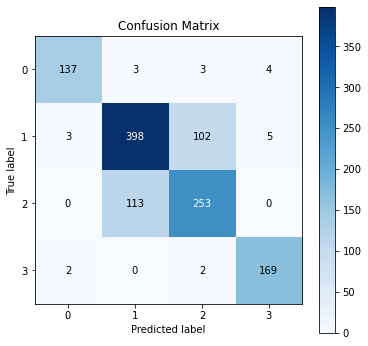

In [168]:
AdaBoost = AdaBoostClassifier(DecisionTreeClassifier(),learning_rate=0.5, n_estimators=15)

#valutazione dei modelli appresi con 10-fold cross-validation
train_score = cross_val_score(AdaBoost, ImagesR, Labels, cv=10)
for i in range (len(train_score)):
    print(f"Accuracy iterazione {i}: {train_score[i]}")
train_score = train_score.mean()
print(f"10-fold Accuracy= {train_score}")

AdaBoost=AdaBoost.fit(x_train,y_train)
print("Accuracy =",AdaBoost.score(x_test,y_test))

y_pred = AdaBoost.predict(x_test)
print(classification_report(y_test, y_pred))

skplt.metrics.plot_confusion_matrix(y_test,y_pred,figsize=(6,6))

#salvataggio modello corrente
with open(os.path.join(modelli_dir,'AdaBoost.pkl'), 'wb') as file:
        pkl.dump(AdaBoost, file)

## Rete Neurale
Una rete neurale convoluzionale funziona, in generale, come tutte le altre feed forward. Essa infatti è costituita da  un blocco di input, uno o più blocchi nascosti (hidden layer), che effettuano calcoli tramite funzioni di attivazione (ad esempio RELU)  e un blocco di output che effettua la classificazione vera e propria. La differenza, infatti,  rispetto alle classiche reti feed forward è rappresentata dalla presenza dei livelli di convoluzione.

Poichè prima avevamo flattenizzato le immagini per utilizzare gli altri classificatori, ora dobbiamo prendere il dataset nella sua forma standard con le 4 dimensioni per rieffettuare lo slit Train/test.

In [123]:
## split train / test

x_train_nn,x_test_nn,y_train_nn,y_test_nn=train_test_split(Images,Labels,train_size=0.80, test_size=0.20)


#aggiungiamo un'altra dimensione relativa alla gray-scale
x_train_nn = np.expand_dims(x_train_nn,axis=3)
x_test_nn = np.expand_dims(x_test_nn,axis=3)

print(x_train_nn.shape, y_train_nn.shape, x_test_nn.shape, y_test_nn.shape)

print('Dimensioni training set: ',len(x_train_nn), len(y_train_nn))
print('Dimensioni validation set: ',len(x_test_nn), len(y_test_nn))

(4772, 80, 60, 1) (4772,) (1194, 80, 60, 1) (1194,)
Dimensioni training set:  4772 4772
Dimensioni validation set:  1194 1194


Definiamo la nostra rete neurale convoluzionale:
* 2 livelli convoluzionali
* 1 livello di max pooling
* 1 livello di average pooling
* 1 livello di global average pooling
* 1 livello di batch normalization
* 1 livello denso + livello softmax
* Activation: RELU
* Optimizer: RMSprop
* Loss: sparse categorical crossentropy

In [124]:
#CNN

model = Sequential()

model.add(Conv2D(32, (5, 5), strides = (1, 1), name = 'conv0', input_shape = (80, 60, 1)))

model.add(BatchNormalization(axis = 3, name = 'bn0'))
model.add(Activation('relu'))

model.add(MaxPooling2D((2, 2), name='max_pool'))
model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
model.add(Activation('relu'))
model.add(AveragePooling2D((3, 3), name='avg_pool'))

model.add(GlobalAveragePooling2D())
model.add(Dense(300, activation="relu", name='rl'))
model.add(Dropout(0.5))
model.add(Dense(4,activation='softmax', name='sm'))

model.compile(optimizer = 'RMSprop', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
#Epoche: 100
reduce_lr = ReduceLROnPlateau(monitor='accuracy', patience=3, verbose=1, factor=0.2, min_lr=1e-25)
history = model.fit(x_train_nn, y_train_nn, batch_size=128, epochs=100, verbose=1, callbacks=[reduce_lr])

test_loss = model.evaluate(x_test_nn,y_test_nn)

#salvataggio del modello
tf.keras.models.save_model(model,os.path.join(modelli_dir,'CNN'))

Epoch 1/100
38/38 [==============================] - 71s 2s/step - loss: 1.2293 - accuracy: 0.4169
Epoch 2/100
38/38 [==============================] - 69s 2s/step - loss: 0.9356 - accuracy: 0.5673
Epoch 3/100
38/38 [==============================] - 69s 2s/step - loss: 0.7388 - accuracy: 0.6793
Epoch 4/100
38/38 [==============================] - 69s 2s/step - loss: 0.6352 - accuracy: 0.7168
Epoch 5/100
38/38 [==============================] - 68s 2s/step - loss: 0.5681 - accuracy: 0.7330
Epoch 6/100
38/38 [==============================] - 70s 2s/step - loss: 0.5299 - accuracy: 0.7498
Epoch 7/100
38/38 [==============================] - 68s 2s/step - loss: 0.5240 - accuracy: 0.7342
Epoch 8/100
38/38 [==============================] - 69s 2s/step - loss: 0.5299 - accuracy: 0.7355
Epoch 9/100
38/38 [==============================] - 67s 2s/step - loss: 0.5008 - accuracy: 0.7541
Epoch 10/100
38/38 [==============================] - 68s 2s/step - loss: 0.5152 - accuracy: 0.7464
Epoch 11/

Vediamo i valori che ci interessano maggiormente accuracy e precision. Mostriamo, inoltre, il grafico di accuracy e loss:

Accuratezza: 0.8458961248397827
Precision on test set:  0.8451823619260149


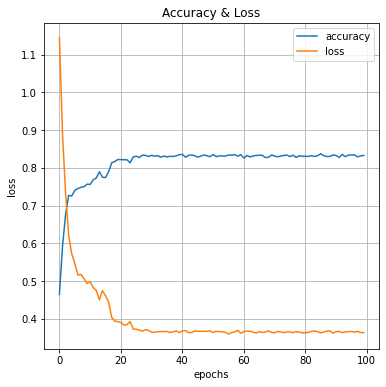

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

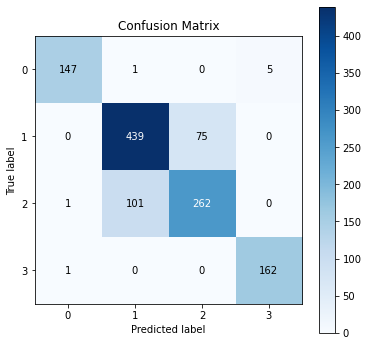

In [126]:
#Accuracy
print( "Accuratezza:" ,test_loss[1])

# Precision
y_pred_nn = model.predict_classes(x_test_nn)
print('Precision on test set: ', metrics.precision_score(y_test_nn, y_pred_nn, average='weighted'))

#Grafico di accuratezza e loss
plt.figure(figsize = (6,6))
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.title('Accuracy & Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()


skplt.metrics.plot_confusion_matrix(y_test_nn, y_pred_nn, figsize=(6,6))

Andiamo ora testare il nostro modello con 10-fold cross validation effettuando nuovamente il passaggio di splitting del dataset in Train e Test set

In [129]:
## split train / test

x_train_nn_f,x_test_nn_f,y_train_nn_f,y_test_nn_f=train_test_split(Images,Labels,train_size=0.80, test_size=0.20)
print(x_train_nn_f.shape, y_train_nn_f.shape, x_test_nn_f.shape, y_test_nn_f.shape)

#aggiungiamo un'altra dimensione relativa alla gray-scale
x_train_nn_f = np.expand_dims(x_train_nn_f,axis=3)
x_test_nn_f = np.expand_dims(x_test_nn_f,axis=3)

print(x_train_nn_f.shape, y_train_nn_f.shape, x_test_nn_f.shape, y_test_nn_f.shape)
print('Dimensioni training set: ',len(x_train_nn_f), len(y_train_nn_f))
print('Dimensioni validation set: ',len(x_test_nn_f), len(y_test_nn_f))

(4772, 80, 60) (4772,) (1194, 80, 60) (1194,)
(4772, 80, 60, 1) (4772,) (1194, 80, 60, 1) (1194,)
Dimensioni training set:  4772 4772
Dimensioni validation set:  1194 1194


In [130]:
# Configurazione del modello
num_folds = 10

fold_accuracy = []
fold_loss = []

inputs = np.concatenate((x_train_nn_f,x_test_nn_f), axis=0)
targets = np.concatenate((y_train_nn_f,y_test_nn_f), axis=0)

#Definizione del K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

In [131]:
fold_count = 1
for train, test in kfold.split(inputs, targets):
    model = Sequential()

    model.add(Conv2D(32, (5, 5), strides = (1, 1), name = 'conv0', input_shape = (80, 60, 1)))

    model.add(BatchNormalization(axis = 3, name = 'bn0'))
    model.add(Activation('relu'))

    model.add(MaxPooling2D((2, 2), name='max_pool'))
    model.add(Conv2D(64, (3, 3), strides = (1,1), name="conv1"))
    model.add(Activation('relu'))
    model.add(AveragePooling2D((3, 3), name='avg_pool'))

    model.add(GlobalAveragePooling2D())
    model.add(Dense(300, activation="relu", name='rl'))
    model.add(Dropout(0.5))
    model.add(Dense(4,activation='softmax', name='sm'))
    
        # Compilazione del modello
    model.compile(optimizer = 'RMSprop', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
    print(f'Training iterazione {fold_count} ...')

    # Adattamento dei dati al modello
    reduce_lr = ReduceLROnPlateau(monitor='accuracy', patience=3, verbose=1, factor=0.2, min_lr=1e-25)
    history1 = model.fit(inputs[train], targets[train], batch_size=128, epochs=10, verbose=1, callbacks=[reduce_lr])

    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    fold_accuracy.append(scores[1] * 100)
    fold_loss.append(scores[0])

    # Passaggio alla  fold successiva
    fold_count = fold_count + 1

Training iterazione 1 ...
Epoch 1/10
42/42 [==============================] - 59s 1s/step - loss: 1.2184 - accuracy: 0.4161
Epoch 2/10
42/42 [==============================] - 53s 1s/step - loss: 0.8768 - accuracy: 0.5971
Epoch 3/10
42/42 [==============================] - 53s 1s/step - loss: 0.7046 - accuracy: 0.6870
Epoch 4/10
42/42 [==============================] - 53s 1s/step - loss: 0.6041 - accuracy: 0.7021
Epoch 5/10
42/42 [==============================] - 53s 1s/step - loss: 0.5707 - accuracy: 0.7090
Epoch 6/10
42/42 [==============================] - 53s 1s/step - loss: 0.5241 - accuracy: 0.7415
Epoch 7/10
42/42 [==============================] - 55s 1s/step - loss: 0.5258 - accuracy: 0.7436
Epoch 8/10
42/42 [==============================] - 53s 1s/step - loss: 0.5340 - accuracy: 0.7321
Epoch 9/10
42/42 [==============================] - 53s 1s/step - loss: 0.4880 - accuracy: 0.7644
Epoch 10/10
42/42 [==============================] - 53s 1s/step - loss: 0.4909 - accuracy: 

Andiamo a visulizzare i risultati ottenuti mostrando i valori di accuracy e di loss per ogni fold:

In [132]:
for i in range(0, len(fold_accuracy)):
    print(f'Fold {i+1}  - Accuracy: {fold_accuracy[i]}  ----  Loss: {fold_loss[i]}')   
print('Average scores totali:')
print(f' Accuracy: {np.mean(fold_accuracy)}  ----  Loss: {np.mean(fold_loss)}')

Fold 1  - Accuracy: 34.50586199760437  ----  Loss: 3.440211296081543
Fold 2  - Accuracy: 31.490787863731384  ----  Loss: 2.741781711578369
Fold 3  - Accuracy: 56.95142149925232  ----  Loss: 1.7609282732009888
Fold 4  - Accuracy: 41.70854389667511  ----  Loss: 1.590614676475525
Fold 5  - Accuracy: 56.95142149925232  ----  Loss: 0.613654375076294
Fold 6  - Accuracy: 21.105527877807617  ----  Loss: 12.496118545532227
Fold 7  - Accuracy: 49.16107356548309  ----  Loss: 3.611999034881592
Fold 8  - Accuracy: 69.96644139289856  ----  Loss: 0.5848281383514404
Fold 9  - Accuracy: 39.93288576602936  ----  Loss: 1.7684141397476196
Fold 10  - Accuracy: 25.33557116985321  ----  Loss: 6.108022212982178
Average scores totali:
 Accuracy: 42.710953652858734  ----  Loss: 3.4716572403907775


## 5 - Anomaly Detection
Il processo di Anomaly Detection consiste nel riconoscimento di condizioni o circostanze inaspettate (ovvero qualcosa che differisce dalla norma) all’interno di un dataset. Parleremo di Anomaly Detection semi-supervisionato ovvero quando una piccola porzione di istanze del dataset viene fornita etichettata mentre il resto dei dati senza etichette.
Il training set sarà composto dalla classe più numerosa del dataset, in questo caso "casual_shoes", ed il test set da quelle restanti: "belts", "sports_shoes" e "wallets".

In [6]:
## c==1 perchè è la classe "casual_shoes" con più immagini rispetto le altre

normal=[] #immagini normali, ovvero tutte le immagini casual_shoes
lab=[] # label nomali (1)
a_lab=[] #label anomali (-1)  
anomaly=[] #immagini anormali, ovvero tutte le rimanenti presenti nelle altre classi: wallets, sport_shoes, belts
c=0
for i in Images:
    if Labels[c]==1:
        normal.append(i)
        lab.append(1)
    else:
        anomaly.append(i)
        a_lab.append(-1)
    c+=1

#poichè abbiamo trasformato le immagini in grayscale dobbiamo aggiungere una dimensione
normal = np.expand_dims(np.array(normal), axis=3)
anomaly = np.expand_dims(np.array(anomaly), axis=3)
norm_labels = np.array(lab, dtype='int32')
anom_labels = np.array(a_lab, dtype='int32')

In [7]:
nsamples, nx, ny, nz = normal.shape
normal1 = normal.reshape((nsamples,nx*ny*nz))

asamples, ax, ay, az = anomaly.shape
anomaly1 = anomaly.reshape((asamples,ax*ay*az))

print(anomaly1.shape)
print(normal1.shape)

(3405, 4800)
(2561, 4800)


Si considera come anomalie tutte le immagini presenti nelle cartelle: "belts", "sports_shoes" e "wallets".

In [9]:
x_train_ad, x_test_ad, y_train_ad, y_test_ad = train_test_split(normal1, norm_labels, test_size=0.3, random_state=42)

test_set = np.append(x_test_ad, anomaly1, axis=0)
test_labels = np.append(y_test_ad, anom_labels)

In [11]:
# ONE CLASS SVM
ocsvm = OneClassSVM(gamma=0.0001, kernel='rbf', nu=0.1).fit(x_train_ad)


y_pred_ad = ocsvm.predict(x_train_ad)
a_pred = ocsvm.predict(anomaly1)

pred = np.append(y_pred_ad, a_pred)
t_labels = np.append(y_train_ad, anom_labels)

#salvataggio modello corrente
with open(os.path.join(modelli_dir,'AnDetOCSVM.pkl'), 'wb') as file:
        pkl.dump(ocsvm, file)

In [12]:
print(classification_report(t_labels, pred))

              precision    recall  f1-score   support

          -1       0.79      1.00      0.88      3405
           1       1.00      0.48      0.65      1792

    accuracy                           0.82      5197
   macro avg       0.89      0.74      0.76      5197
weighted avg       0.86      0.82      0.80      5197



Per valutare il detector facciamo uso delle **curve di ROC**.
La curva ROC viene costruita considerando tutti i possibili valori del test e, per ognuno di questi, calcola la proporzione di veri positivi e la proporzione di falsi positivi. Congiungendo i punti che mettono in rapporto la proporzione di veri positivi e di falsi positivi (le cosiddette coordinate) si ottiene una curva chiamata, appunto, **curva ROC**. L’area sottostante alla curva ROC (AUC, acronimo dei termini inglesi “Area Under the Curve”) è una misura di accuratezza.

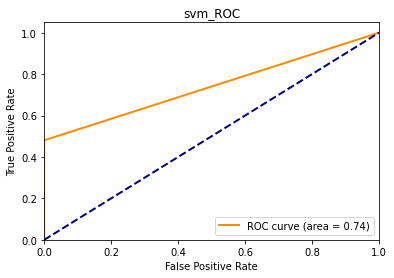

In [13]:
# Calcola la curva ROC e l'area ROC per le previsioni sul set di convalida
fpr, tpr, _ = roc_curve(t_labels, pred)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('svm_ROC')
plt.legend(loc="lower right")
plt.show()

L’area sotto la curva può assumere valori compresi tra 0.5 e 1.0. Tanto maggiore è l’area sotto la curva (cioè tanto più la curva si avvicina al vertice del grafico) tanto maggiore è il potere discriminante del test. Per l’interpretazione dei valori dell’area sottostante la curva ROC se si ha:
1. AUC=0.5 il test non è informativo;
2. 0.5<AUC≤0.7 il test è poco accurato;
3. 0.7<AUC≤0.9 il test è moderatamente accurato;
4. 0.9<AUC<1.0 il test è altamente accurato;
5. AUC=1 test perfetto.

Nel nostro caso l'area risulta 0.50 e quindi il test non risulta informativo

Proviamo ad utilizzare un altro algoritmo per la classificazione:

In [14]:
#IsolationForest
Iso_f = IsolationForest( n_estimators=500, random_state=0).fit(x_train_ad)


y_pred_ad = Iso_f.predict(x_train_ad)
a_pred = Iso_f.predict(anomaly1)

pred = np.append(y_pred_ad, a_pred)
t_labels = np.append(y_train_ad, anom_labels)


#salvataggio modello corrente
with open(os.path.join(modelli_dir,'AnDetIsolationForest.pkl'), 'wb') as file:
        pkl.dump(Iso_f, file)

In [15]:
print(classification_report(t_labels, pred))

              precision    recall  f1-score   support

          -1       0.88      0.23      0.37      3405
           1       0.39      0.94      0.55      1792

    accuracy                           0.48      5197
   macro avg       0.64      0.59      0.46      5197
weighted avg       0.71      0.48      0.43      5197



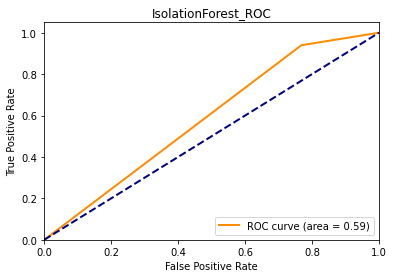

In [16]:
# Calcola la curva ROC e l'area ROC per le previsioni sul set di convalida
fpr, tpr, _ = roc_curve(t_labels, pred)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('IsolationForest_ROC')
plt.legend(loc="lower right")
plt.show()

In [17]:
#LocalOutlierFactor
LocalOutFact = LocalOutlierFactor(n_neighbors=20, algorithm='auto', leaf_size=30, metric='minkowski', p=2, contamination='auto', novelty=True).fit(x_train_ad)


y_pred_ad = LocalOutFact.predict(x_train_ad)
a_pred = LocalOutFact.predict(anomaly1)

pred = np.append(y_pred_ad, a_pred)
t_labels = np.append(y_train_ad, anom_labels)

#salvataggio modello corrente
with open(os.path.join(modelli_dir,'AnDetLocalOutFact.pkl'), 'wb') as file:
        pkl.dump(LocalOutFact, file)

In [18]:
print(classification_report(t_labels, pred))

              precision    recall  f1-score   support

          -1       0.98      0.48      0.64      3405
           1       0.50      0.98      0.66      1792

    accuracy                           0.65      5197
   macro avg       0.74      0.73      0.65      5197
weighted avg       0.82      0.65      0.65      5197



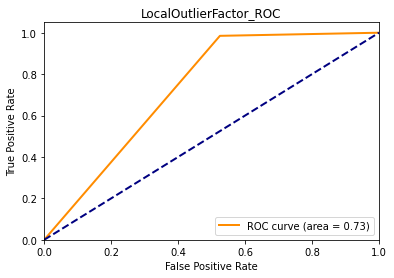

In [19]:
# Calcola la curva ROC e l'area ROC per le previsioni sul set di convalida
fpr, tpr, _ = roc_curve(t_labels, pred)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LocalOutlierFactor_ROC')
plt.legend(loc="lower right")
plt.show()